# Fit double components

In this notebook we will create a syntehtic SN3 spectrum with two Halpha components. We will then fit spectrum and plot the fit.


In [1]:
# Imports
import sys
sys.path.insert(0, '/home/carterrhea/Documents/LUCI/')  # Location of Luci
from LUCI.LuciSim import Spectrum
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from  scipy import interpolate
import LUCI.LuciFit as lfit
import keras

In [2]:
# Create first spectrum
lines = ['Halpha', 'NII6583', 'NII6548', 'SII6716', 'SII6731']
fit_function = 'sincgauss'
ampls = [2, .9, 0.3, 0.25, 0.25]  # Just randomly choosing these
velocity = 0  # km/s
broadening = 20  # km/s
filter_ = 'SN3'
resolution = 5000
snr = 50

spectrum_axis, spectrum = Spectrum(lines, fit_function, ampls, velocity, broadening, filter_, resolution, snr).create_spectrum()

In [3]:
# Now create the second spectrum and add them together
lines = ['Halpha']
ampls = [1]  # Just randomly chosen
velocity = 200  # km/s

spectrum_axis2, spectrum2 = Spectrum(lines, fit_function, ampls, velocity, broadening, filter_, resolution, snr).create_spectrum()

# Add them together
spectrum += spectrum2


In [4]:
# And we can now take a look

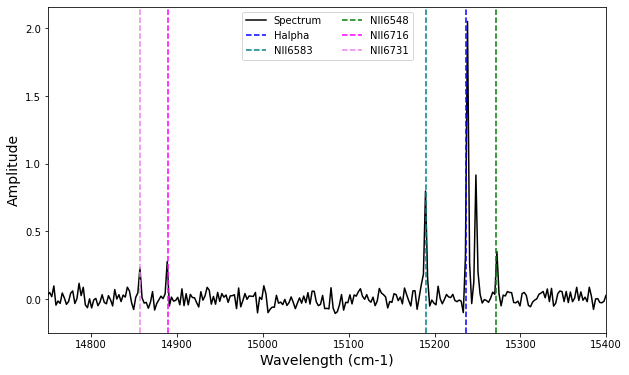

In [5]:
plt.figure(figsize=(10,6))
plt.plot(spectrum_axis, spectrum, color='black', label='Spectrum')
plt.xlim(14750, 15400)
plt.xlabel('Wavelength (cm-1)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.axvline(1e7/656.3, label='Halpha', color='blue', linestyle='--')
plt.axvline(1e7/658.3, label='NII6583', color='teal', linestyle='--')
plt.axvline(1e7/654.8, label='NII6548', color='green', linestyle='--')
plt.axvline(1e7/671.6, label='NII6716', color='magenta', linestyle='--')
plt.axvline(1e7/673.1, label='NII6731', color='violet', linestyle='--')
plt.legend(ncol=2)

plt.show()

We can clearly see that something is up with the Halpha line (because wd threw a second one there of course). Next, we can fit the components.

In [6]:
# Machine Learning Reference Spectrum
ref_spec = fits.open('/home/carterrhea/Documents/LUCI/ML/Reference-Spectrum-R5000-SN3.fits')[1].data
channel = []
counts = []
for chan in ref_spec:  # Only want SN3 region
    channel.append(chan[0])
    counts.append(np.real(chan[1]))
min_ = np.argmin(np.abs(np.array(channel)-14700))
max_ = np.argmin(np.abs(np.array(channel)-15600))
wavenumbers_syn = channel[min_:max_]
f = interpolate.interp1d(spectrum_axis, spectrum, kind='slinear')
sky_corr = (f(wavenumbers_syn))
sky_corr_scale = np.max(sky_corr)
sky_corr = sky_corr/sky_corr_scale

In [7]:
fit = lfit.Fit(spectrum, spectrum_axis, wavenumbers_syn, 'sincgauss', 
               ['Halpha', 'NII6583', 'NII6548','SII6716', 'SII6731', 'Halpha'], 
               [1,1,1,1,1,2], [1,1,1,1,1,2],
               #['Halpha', 'NII6583', 'NII6548','SII6716', 'SII6731'], 
               #[1,1,1,1,1], [1,1,1,1,1], 
               keras.models.load_model('/home/carterrhea/Documents/LUCI/ML/R5000-PREDICTOR-I-SN3'),
               bayes_bool=True
                 )
fit_dict = fit.fit()


2022-03-24 14:57:12.481843: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-24 14:57:12.482775: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
fit_dict['velocities']

[-45.71626482347676,
 -13.67651252050525,
 14.405615705006783,
 -24.34115712134063,
 -1.8427934653198184,
 -214.57658641058953]

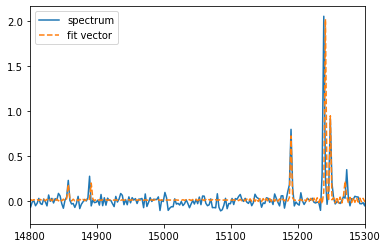

In [9]:
plt.plot(spectrum_axis, spectrum, label='spectrum')
plt.plot(spectrum_axis, fit_dict['fit_vector'], label='fit vector', linestyle='--')
plt.xlim(14800, 15300)
plt.legend()

In [10]:
#fit_dict